In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec

In [189]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True

In [190]:
figdir = '../../../Figures/Components'

# Load data

In [2]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [23]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

In [30]:
activation_threshold = 0.0625
cc_geps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']

dataset = 'Pan-Cancer'
individual_col = params.loc[dataset, 'individual_col']
sample_col = params.loc[dataset, 'sample_col']
activation = pd.read_csv(params.loc[dataset, 'activation_score_fn'], sep='\t', index_col=0)
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep='\t', index_col=0)
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

meta['Activation_Score'] = activation.loc[meta.index, 'Activation_Score']
meta['Activation_Status'] = meta['Activation_Score'] > activation_threshold
meta['CellCycle_Usage'] = usage_norm.loc[activation.index, cc_geps].sum(axis=1)
meta['Exhaustion_Usage'] = usage_norm.loc[activation.index, 'Exhaustion']
meta['CellCycle_Bin'] = meta['CellCycle_Usage']>activation_threshold
meta['Exhaustion_Bin'] = meta['Exhaustion_Usage']>activation_threshold

meta.rename(columns={individual_col:'individual', sample_col:'sample'}, inplace=True)

meta.head()

,patient,cellID,libraryID,cancerType,loc,batchV,TCR,dataset,ClusterID,dataset.tech,...,individual,tech,batch,n_counts,Activation_Score,Activation_Status,CellCycle_Usage,Exhaustion_Usage,CellCycle_Bin,Exhaustion_Bin
bcc.su001.pre.tcell_AAACGGGTCATACGGT-0,su001,bcc.su001.pre.tcell_AAACGGGTCATACGGT,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C20,KathrynEYost2019,...,BCC.KathrynEYost2019.su001,10X,0,2556.0,0.031491,False,0.002633,0.003581,False,False
bcc.su001.pre.tcell_AAAGATGGTTTGGGCC-0,su001,bcc.su001.pre.tcell_AAAGATGGTTTGGGCC,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C20,KathrynEYost2019,...,BCC.KathrynEYost2019.su001,10X,0,4876.0,0.074126,True,0.034528,0.022445,False,False
bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA-0,su001,bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C01,KathrynEYost2019,...,BCC.KathrynEYost2019.su001,10X,0,4302.0,0.180084,True,0.008120,0.003396,False,False
bcc.su001.pre.tcell_AAAGTAGGTATATGAG-0,su001,bcc.su001.pre.tcell_AAAGTAGGTATATGAG,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C08,KathrynEYost2019,...,BCC.KathrynEYost2019.su001,10X,0,3271.0,0.059935,False,0.010514,0.001775,False,False
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG-0,su001,bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG,bcc.su001.pre.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C02,KathrynEYost2019,...,BCC.KathrynEYost2019.su001,10X,0,8025.0,0.447959,True,0.001467,0.001102,False,False


In [63]:
meta['cancerType'].replace({'BC', 'BRCA'})

bcc.su001.pre.tcell_AAACGGGTCATACGGT-0     BCC
bcc.su001.pre.tcell_AAAGATGGTTTGGGCC-0     BCC
bcc.su001.pre.tcell_AAAGCAAAGCAGGTCA-0     BCC
bcc.su001.pre.tcell_AAAGTAGGTATATGAG-0     BCC
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG-0     BCC
                                          ... 
TTGGAACGTCGGCACT-88-29                    UCEC
TTGGAACTCACTTACT-88-29                    UCEC
TTTACTGAGACCACGA-88-29                    UCEC
TTTATGCAGGCAATTA-88-29                    UCEC
TTTCCTCTCACTATTC-88-29                    UCEC
Name: cancerType, Length: 215035, dtype: object

In [31]:
meta['orig.individual'] = meta['individual']
meta['individual'] = meta['individual'].astype(str) + '.' + meta['loc'].astype(str)

In [32]:
final_category = {'CD8.Tm':'CD8 Conv',
 'CD8.Tem':'CD8 Conv',
 'CD8.Trm':'CD8 Conv',
 'CD8.Tex':'CD8 Conv',
 'CD8.Temra':'CD8 Conv',
 'CD8.Tn':'CD8 Conv',
 'CD8.MAIT':'CD8 Conv',
 'CD8.Tk':'CD8 Conv',
 'CD8.ISG':'CD8 Conv',

 'CD4.Treg':'CD4 Treg',

 'CD4.Tm':'CD4 Conv',
 'CD4.Tn':'CD4 Conv',
 
 
 'CD4.Tfh':'CD4 Conv',
 'CD4.Th17':'CD4 Conv',
 'CD4.Tem':'CD4 Conv',
 'CD4.Temra':'CD4 Conv',
 'CD4.TfhTh1':'CD4 Conv',
 'CD4.Mix':'CD4 Conv',
 'CD4.ISG':'CD4 Conv'}

meta['meta.cluster.short'] = meta['meta.cluster'].apply(lambda x: '.'.join(np.array(x.split('.'))[[0, 2]]))
meta['lineage'] = meta['meta.cluster.short'].replace(final_category)

# Filter duplicates

In [33]:
ct = pd.crosstab(meta['individual'], meta['sample'])    
display((ct>0).sum(axis=1).value_counts())
ind = (ct>0).sum(axis=1)>1
ct = ct.loc[ind, :]
tokeep = ct.loc[:, (ct>0).sum(axis=0)>0].idxmax(axis=1)

tofilt = meta['individual'].isin(tokeep.index) & ~meta['sample'].isin(tokeep.values)
meta_filt = meta.loc[~tofilt, :]
ct = pd.crosstab(meta_filt['individual'], meta_filt['sample'])
display((ct>0).sum(axis=1).value_counts())

1    113
2     12
4      7
3      4
dtype: int64

1    136
dtype: int64

# Correlate with mutation burden

In [153]:
lineage = 'CD4 Conv'
readout = 'Activation_Status'
mincells = 10
mintumors = 0

mutation_buden = pd.read_csv('../../../Data/PerDataset/Pancancer/panC.TMB.txt', sep='\t', header=None)
mutation_buden['log'] = mutation_buden[2].apply(np.log10)
mutation_buden.head()

,0,1,2,log
0,BC.P20190123,BC,0.397868,-0.400261
1,BC.P20190403,BC,0.233919,-0.630934
2,CHOL.P0216,CHOL,0.989222,-0.004706
3,CRC.P0123,CRC,23.897304,1.378349
4,CRC.P0215,CRC,2.801537,0.447396


In [176]:
def fix_name(x, pos1=0, pos2=3):
    words = x.split('.')
    return('.'.join([words[pos1], words[pos2]]))

meta_filt['individual_fix'] = meta_filt['individual'].apply(lambda x: fix_name(x))
ind = meta_filt['cancerType'] == 'BC'
meta_filt.loc[ind, 'individual_fix'] = meta_filt.loc[ind, 'individual_fix'].apply(lambda x: x.replace('BRCA', 'BC'))

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


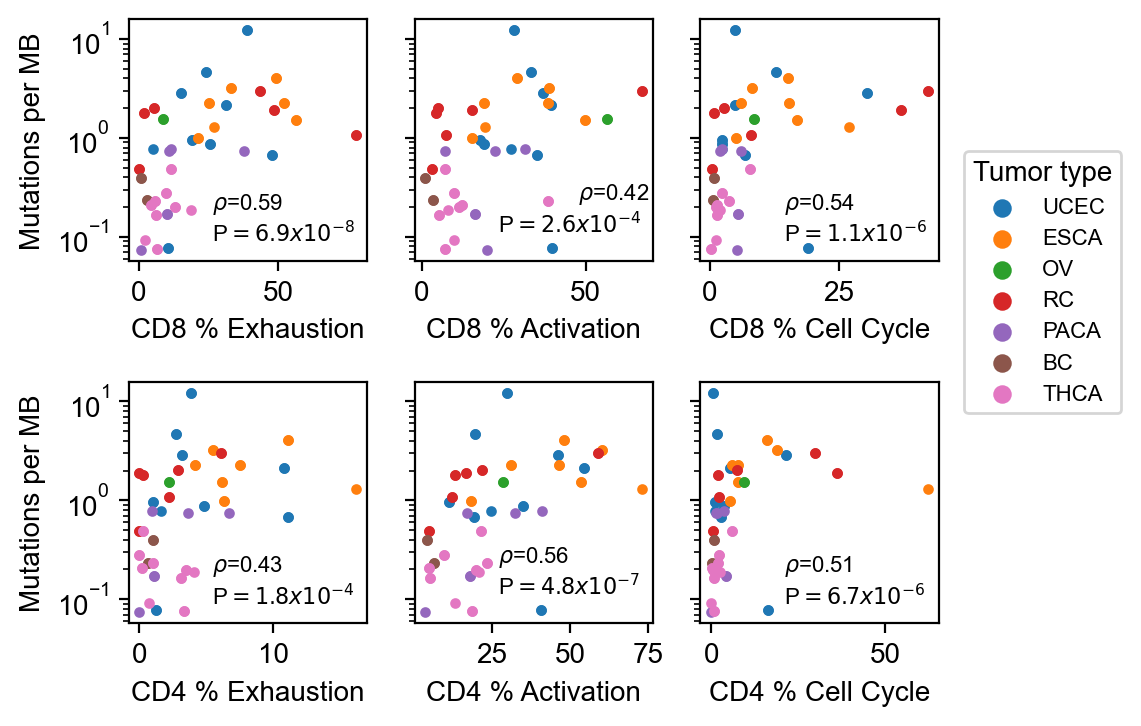

In [265]:
labelsize = 10
insetsize = 8
(fig,axes) = plt.subplots(2,3, figsize=(6,4), dpi=200, gridspec_kw={'hspace':.5, 'right':.8}, sharey=True)
typeorder = ['UCEC', 'ESCA', 'OV', 'RC', 'PACA', 'BC', 'THCA']
s=8

for i, lineage in enumerate(['CD8 Conv', 'CD4 Conv']):
    for j, readout in enumerate(['Exhaustion_Bin', 'Activation_Status', 'CellCycle_Bin']):

        ind = (meta_filt['lineage'] == lineage)
        dat = meta_filt.loc[ind, :]

        sample_stats = dat.groupby(['individual_fix', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={readout:'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
        tumors_to_filt = num_tumors.index[num_tumors<mintumors]
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]


        sample_average = (dat.groupby(['individual_fix', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual_fix', 'Ncell']], on='individual_fix', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]

        sample_average_tumor = sample_average.loc[sample_average['loc']=='T', :]

        merged = pd.merge(left=sample_average_tumor, right=mutation_buden, left_on='individual_fix', right_on=0, how='inner')

        
        for k in typeorder:
            g = merged.loc[merged['cancerType']==k, :]
            axes[i, j].scatter(g[readout], g[2], label=k, s=s)
            
            
        axes[i,j].set_yscale('log')
        
        R, P = spearmanr(merged[readout], merged[2])
        exponent = int(np.floor(np.log10(P)))
        mantissa = P / 10**exponent
        
        if (i == 0) and (j==1):
            axes[i,j].text(.35, .12, r'             $\rho$' + ('=%.2f\n' % R) + 'P$={:.1f}x10^{{{}}}$'.format(mantissa, exponent), fontsize=insetsize,
                       transform=axes[i,j].transAxes, ha='left')            
        elif (i == 1) and (j==1):
            axes[i,j].text(.35, .12, r'$\rho$' + ('=%.2f\n' % R) + 'P$={:.1f}x10^{{{}}}$'.format(mantissa, exponent), fontsize=insetsize,
                       transform=axes[i,j].transAxes, ha='left')
        else:
            axes[i,j].text(.35, .08, r'$\rho$' + ('=%.2f\n' % R) + 'P$={:.1f}x10^{{{}}}$'.format(mantissa, exponent), fontsize=insetsize,
                       transform=axes[i,j].transAxes, ha='left')
        
        

        
        if j == 0:
            axes[i,j].set_ylabel('Mutations per MB', fontsize=labelsize)
            
        if (i == 0) and (j==2):
            axes[i,j].legend(bbox_to_anchor=(1.06,.5), title='Tumor type', markerscale=2, fontsize=insetsize)
        actname = '% '+readout.split('_')[0].replace('Cell', 'Cell ')
        axes[i,j].set_xlabel('%s %s' % (lineage.split(' ')[0], actname), fontsize=labelsize) 
        
plt.savefig(os.path.join(figdir, 'PanCancer_TMB_Vs_Activation_All.pdf'))
plt.savefig(os.path.join(figdir, 'PanCancer_TMB_Vs_Activation_All.png'))

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


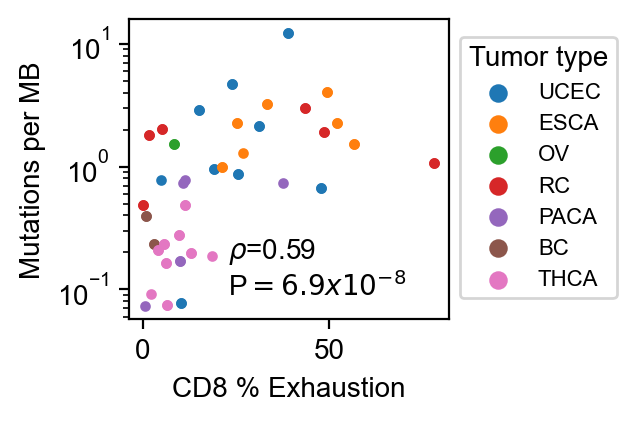

In [274]:
labelsize = 10
insetsize = 8
(fig,ax) = plt.subplots(1,1, figsize=(3.2,2), dpi=200, gridspec_kw={'right':.7, 'left':.2, 'bottom':.22, 'top':.97})
typeorder = ['UCEC', 'ESCA', 'OV', 'RC', 'PACA', 'BC', 'THCA']
s=8

lineage = 'CD8 Conv'
readout ='Exhaustion_Bin'

ind = (meta_filt['lineage'] == lineage)
dat = meta_filt.loc[ind, :]

sample_stats = dat.groupby(['individual_fix', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={readout:'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]


sample_average = (dat.groupby(['individual_fix', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual_fix', 'Ncell']], on='individual_fix', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]

sample_average_tumor = sample_average.loc[sample_average['loc']=='T', :]

merged = pd.merge(left=sample_average_tumor, right=mutation_buden, left_on='individual_fix', right_on=0, how='inner')

        
for k in typeorder:
    g = merged.loc[merged['cancerType']==k, :]
    ax.scatter(g[readout], g[2], label=k, s=s)
            
            
ax.set_yscale('log')
        
R, P = spearmanr(merged[readout], merged[2])
exponent = int(np.floor(np.log10(P)))
mantissa = P / 10**exponent
        
ax.text(.31, .08, r'$\rho$' + ('=%.2f\n' % R) + 'P$={:.1f}x10^{{{}}}$'.format(mantissa, exponent), fontsize=labelsize,
                       transform=ax.transAxes, ha='left')
        
ax.set_ylabel('Mutations per MB', fontsize=labelsize)
ax.legend(bbox_to_anchor=(1.0,0.98), title='Tumor type', markerscale=2, fontsize=insetsize)
ax.set_xlabel('%s %s' % (lineage.split(' ')[0], ('% '+readout.split('_')[0])), fontsize=labelsize) 
        
plt.savefig(os.path.join(figdir, 'PanCancer_TMB_Vs_Activation_CD8Exhaust.pdf'))
plt.savefig(os.path.join(figdir, 'PanCancer_TMB_Vs_Activation_CD8Exhaust.png'))

In [233]:
dat

,patient,cellID,libraryID,cancerType,loc,batchV,TCR,dataset,ClusterID,dataset.tech,...,Activation_Score,Activation_Status,CellCycle_Usage,Exhaustion_Usage,CellCycle_Bin,Exhaustion_Bin,orig.individual,meta.cluster.short,lineage,individual_fix
bcc.su001.post.tcell_AAACCTGCACGCATCG-1,su001,bcc.su001.post.tcell_AAACCTGCACGCATCG,bcc.su001.post.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C01,KathrynEYost2019,...,0.020268,False,0.009330,0.032113,False,False,BCC.KathrynEYost2019.su001,CD8.Tm,CD8 Conv,BCC.T
bcc.su001.post.tcell_AAACCTGCAGATGGGT-1,su001,bcc.su001.post.tcell_AAACCTGCAGATGGGT,bcc.su001.post.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C01,KathrynEYost2019,...,0.019634,False,0.002035,0.006278,False,False,BCC.KathrynEYost2019.su001,CD8.Tm,CD8 Conv,BCC.T
bcc.su001.post.tcell_AAACCTGCATGCCTTC-1,su001,bcc.su001.post.tcell_AAACCTGCATGCCTTC,bcc.su001.post.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C03,KathrynEYost2019,...,0.046185,False,0.005267,0.034606,False,False,BCC.KathrynEYost2019.su001,CD8.Tex,CD8 Conv,BCC.T
bcc.su001.post.tcell_AAACCTGTCAGGTTCA-1,su001,bcc.su001.post.tcell_AAACCTGTCAGGTTCA,bcc.su001.post.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C00,KathrynEYost2019,...,0.039166,False,0.008354,0.011767,False,False,BCC.KathrynEYost2019.su001,CD8.Tem,CD8 Conv,BCC.T
bcc.su001.post.tcell_AAACGGGGTAAATACG-1,su001,bcc.su001.post.tcell_AAACGGGGTAAATACG,bcc.su001.post.tcell,BCC,T,su001,NaN,BCC.KathrynEYost2019,BCC.KathrynEYost2019.C00,KathrynEYost2019,...,0.013549,False,0.002637,0.031233,False,False,BCC.KathrynEYost2019.su001,CD8.Tk,CD8 Conv,BCC.T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGAACGTCGGCACT-88-29,UCEC.P20190911,TTGGAACGTCGGCACT-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C11,zhangLab5P,...,0.037106,False,0.006088,0.018516,False,False,UCEC.thisStudy.UCEC.P20190911,CD8.Tm,CD8 Conv,UCEC.P20190911
TTGGAACTCACTTACT-88-29,UCEC.P20190911,TTGGAACTCACTTACT-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C02,zhangLab5P,...,0.011973,False,0.000867,0.007465,False,False,UCEC.thisStudy.UCEC.P20190911,CD8.Tm,CD8 Conv,UCEC.P20190911
TTTACTGAGACCACGA-88-29,UCEC.P20190911,TTTACTGAGACCACGA-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C16,zhangLab5P,...,0.058761,False,0.235870,0.042641,True,False,UCEC.thisStudy.UCEC.P20190911,CD8.Tm,CD8 Conv,UCEC.P20190911
TTTATGCAGGCAATTA-88-29,UCEC.P20190911,TTTATGCAGGCAATTA-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C15,zhangLab5P,...,0.001649,False,0.000937,0.001480,False,False,UCEC.thisStudy.UCEC.P20190911,CD8.Temra,CD8 Conv,UCEC.P20190911


In [207]:
merged['cancerType']

,individual_fix,loc,cancerType,CellCycle_Bin,Activation_Status,Exhaustion_Bin,Ncell,0,1,2,log
0,BC.P20190123,T,BC,0.815661,1.060359,0.815661,2010,BC.P20190123,BC,0.397868,-0.400261
1,BC.P20190123,T,BC,0.815661,1.060359,0.815661,1226,BC.P20190123,BC,0.397868,-0.400261
2,BC.P20190403,T,BC,0.550206,3.301238,3.026135,328,BC.P20190403,BC,0.233919,-0.630934
3,BC.P20190403,T,BC,0.550206,3.301238,3.026135,727,BC.P20190403,BC,0.233919,-0.630934
4,ESCA.P20181114,T,ESCA,4.985618,15.244487,21.188878,358,ESCA.P20181114,ESCA,0.995432,-0.001988
...,...,...,...,...,...,...,...,...,...,...,...
65,UCEC.P20190717,T,UCEC,2.380952,17.857143,19.047619,168,UCEC.P20190717,UCEC,0.958131,-0.018575
66,UCEC.P20190910,T,UCEC,30.512515,36.948749,15.017878,539,UCEC.P20190910,UCEC,2.866282,0.457319
67,UCEC.P20190910,T,UCEC,30.512515,36.948749,15.017878,1678,UCEC.P20190910,UCEC,2.866282,0.457319
68,UCEC.P20190911,T,UCEC,18.957346,39.810427,10.426540,1270,UCEC.P20190911,UCEC,0.077164,-1.112584


In [203]:
dat['cancerType'].unique()

array(['BCC', 'BCL', 'BC', 'ESCA', 'FTC', 'HCC', 'LUNG', 'MM', 'OV',
       'PACA', 'RC', 'THCA', 'UCEC'], dtype=object)

In [171]:
sample_average_tumor

,individual_fix,loc,cancerType,CellCycle_Bin,Activation_Status,Exhaustion_Bin,Ncell
0,BCC.T,T,BCC,7.152549,39.716999,9.769335,5159
1,BCL.P20181123,T,BCL,0.256410,7.179487,19.487179,390
2,BCL.P20190404,T,BCL,1.486989,21.747212,16.542751,538
5,BRCA.P20190123,T,BC,0.917431,4.357798,1.032110,620
6,BRCA.P20190123,T,BC,0.917431,4.357798,1.032110,872
...,...,...,...,...,...,...,...
163,UCEC.P20190717,T,UCEC,1.020408,11.224490,1.020408,196
166,UCEC.P20190910,T,UCEC,21.493902,46.189024,3.201220,96
167,UCEC.P20190910,T,UCEC,21.493902,46.189024,3.201220,656
170,UCEC.P20190911,T,UCEC,16.393443,40.573770,1.229508,675


In [172]:
mutation_buden

,0,1,2,log
0,BC.P20190123,BC,0.397868,-0.400261
1,BC.P20190403,BC,0.233919,-0.630934
2,CHOL.P0216,CHOL,0.989222,-0.004706
3,CRC.P0123,CRC,23.897304,1.378349
4,CRC.P0215,CRC,2.801537,0.447396
...,...,...,...,...
83,UCEC.P20190625,UCEC,2.143195,0.331062
84,UCEC.P20190717,UCEC,0.958131,-0.018575
85,UCEC.P20190722,UCEC,0.757408,-0.120670
86,UCEC.P20190910,UCEC,2.866282,0.457319


/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


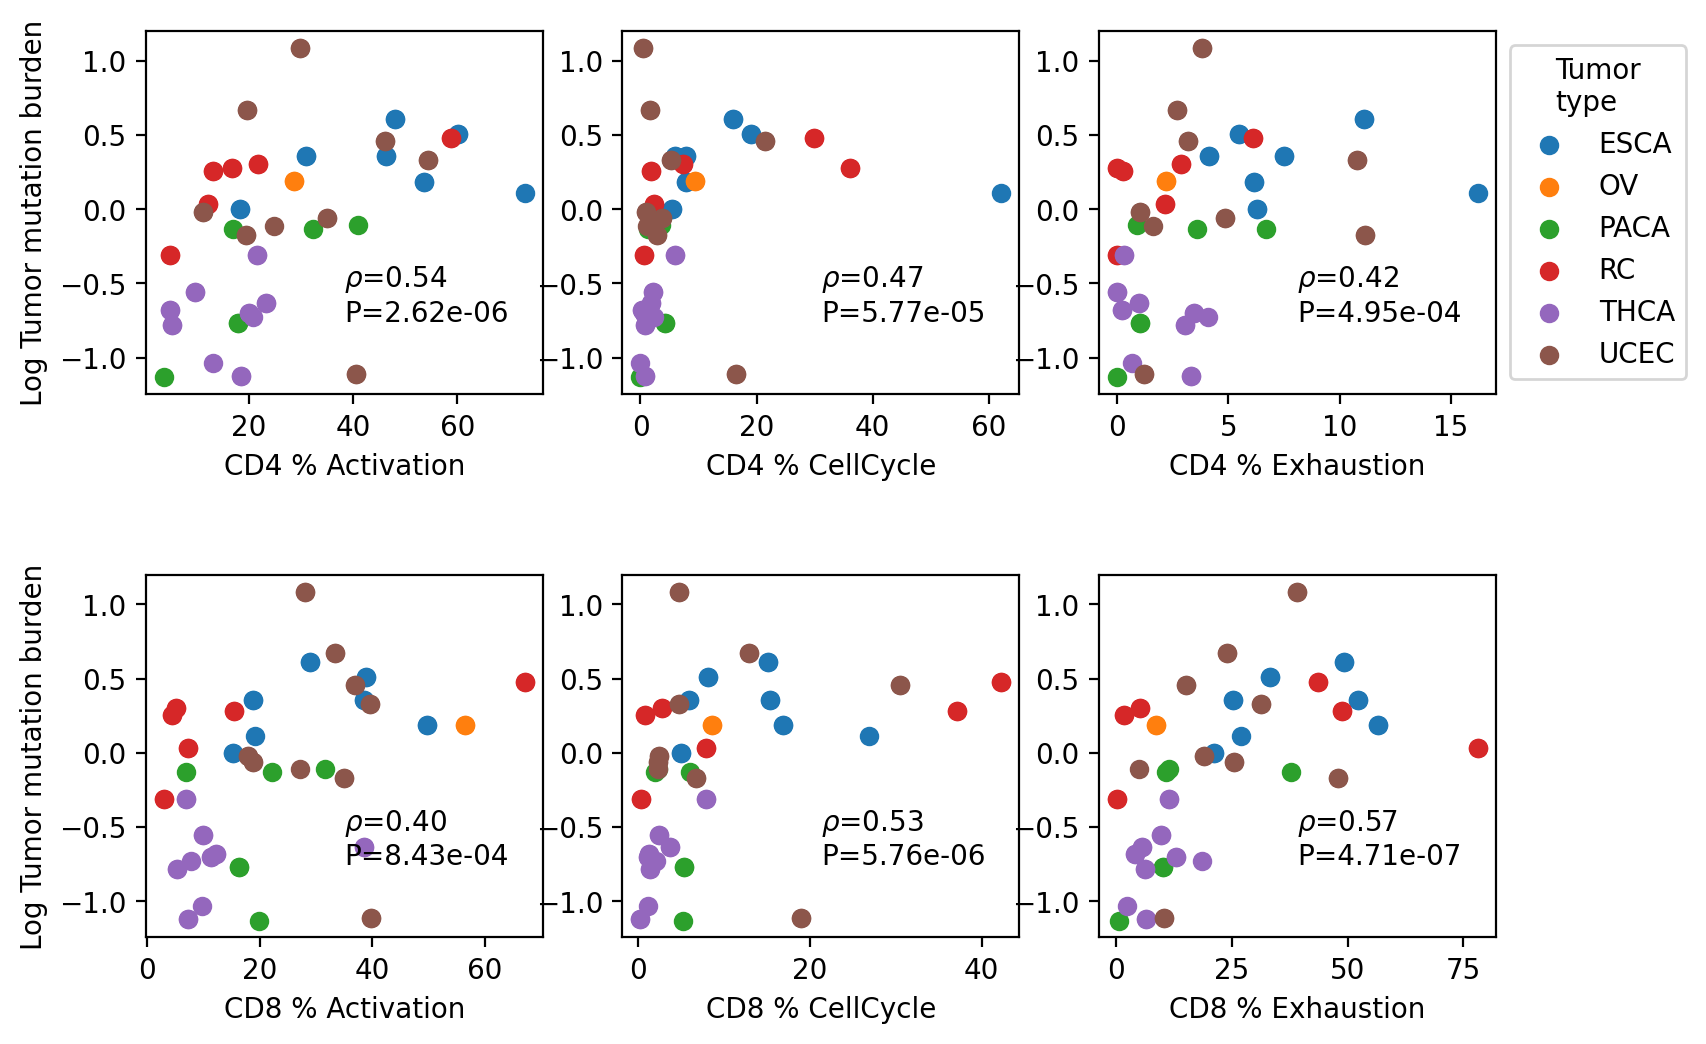

In [156]:
labelsize = 10
(fig,axes) = plt.subplots(2,3, figsize=(10,6), dpi=200, gridspec_kw={'hspace':.5, 'right':.8})

for i, lineage in enumerate(['CD4 Conv', 'CD8 Conv']):
    for j, readout in enumerate(['Activation_Status', 'CellCycle_Bin', 'Exhaustion_Bin']):

        ind = (meta_filt['lineage'] == lineage)
        dat = meta_filt.loc[ind, :]

        sample_stats = dat.groupby(['individual_fix', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={readout:'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
        tumors_to_filt = num_tumors.index[num_tumors<mintumors]
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        sample_average = (dat.groupby(['individual_fix', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual_fix', 'Ncell']], on='individual_fix', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]

        sample_average_tumor = sample_average.loc[sample_average['loc']=='T', :]
        merged = pd.merge(left=sample_average_tumor, right=mutation_buden, left_on='individual_fix', right_on=0, how='inner')

        for (k,g) in merged.groupby('cancerType'):
            axes[i, j].scatter(g[readout], g['log'], label=k)
        
        R, P = spearmanr(merged[readout], merged['log'])
        axes[i,j].text(.5, .2, r'$\rho$' + '=%.2f\nP=%.2e' % (R, P), fontsize=labelsize, transform=axes[i,j].transAxes)
        
        if j == 0:
            axes[i,j].set_ylabel('Log Tumor mutation burden', fontsize=labelsize)
            
        if (i == 0) and (j==2):
            axes[i,j].legend(bbox_to_anchor=(1,1), title='Tumor\ntype')
            
        axes[i,j].set_xlabel('%s %s' % (lineage.split(' ')[0], ('% '+readout.split('_')[0])), fontsize=labelsize)    

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


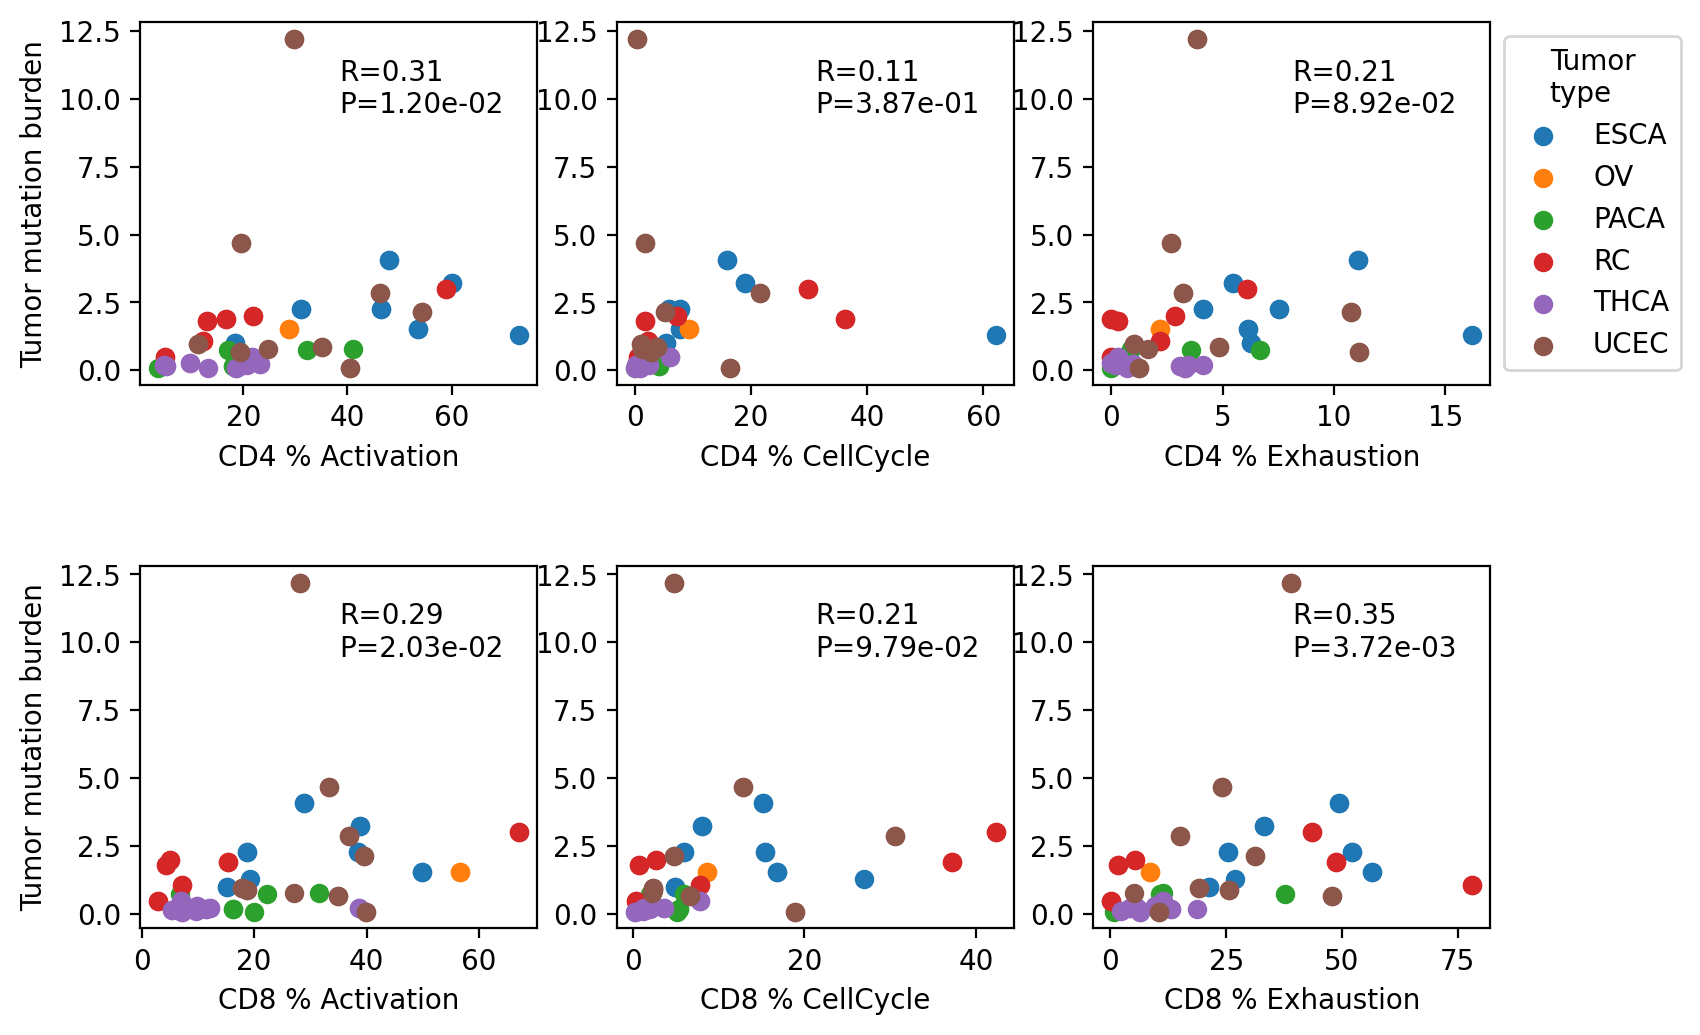

In [152]:
labelsize = 10
(fig,axes) = plt.subplots(2,3, figsize=(10,6), dpi=200, gridspec_kw={'hspace':.5, 'right':.8})

for i, lineage in enumerate(['CD4 Conv', 'CD8 Conv']):
    for j, readout in enumerate(['Activation_Status', 'CellCycle_Bin', 'Exhaustion_Bin']):

        ind = (meta_filt['lineage'] == lineage)
        dat = meta_filt.loc[ind, :]

        sample_stats = dat.groupby(['individual_fix', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={readout:'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
        tumors_to_filt = num_tumors.index[num_tumors<mintumors]
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        sample_average = (dat.groupby(['individual_fix', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual_fix', 'Ncell']], on='individual_fix', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]

        sample_average_tumor = sample_average.loc[sample_average['loc']=='T', :]
        merged = pd.merge(left=sample_average_tumor, right=mutation_buden, left_on='individual_fix', right_on=0, how='inner')

        for (k,g) in merged.groupby('cancerType'):
            axes[i, j].scatter(g[readout], g[2], label=k)
        
        R, P = pearsonr(merged[readout], merged[2])
        axes[i,j].text(.5, .75, 'R=%.2f\nP=%.2e' % (R, P), fontsize=labelsize, transform=axes[i,j].transAxes)
        
        if j == 0:
            axes[i,j].set_ylabel('Tumor mutation burden', fontsize=labelsize)
            
        if (i == 0) and (j==2):
            axes[i,j].legend(bbox_to_anchor=(1,1), title='Tumor\ntype')
            
        axes[i,j].set_xlabel('%s %s' % (lineage.split(' ')[0], ('% '+readout.split('_')[0])), fontsize=labelsize)     

/PHShome/dk718/miniforge3/envs/cnmf_env2v3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


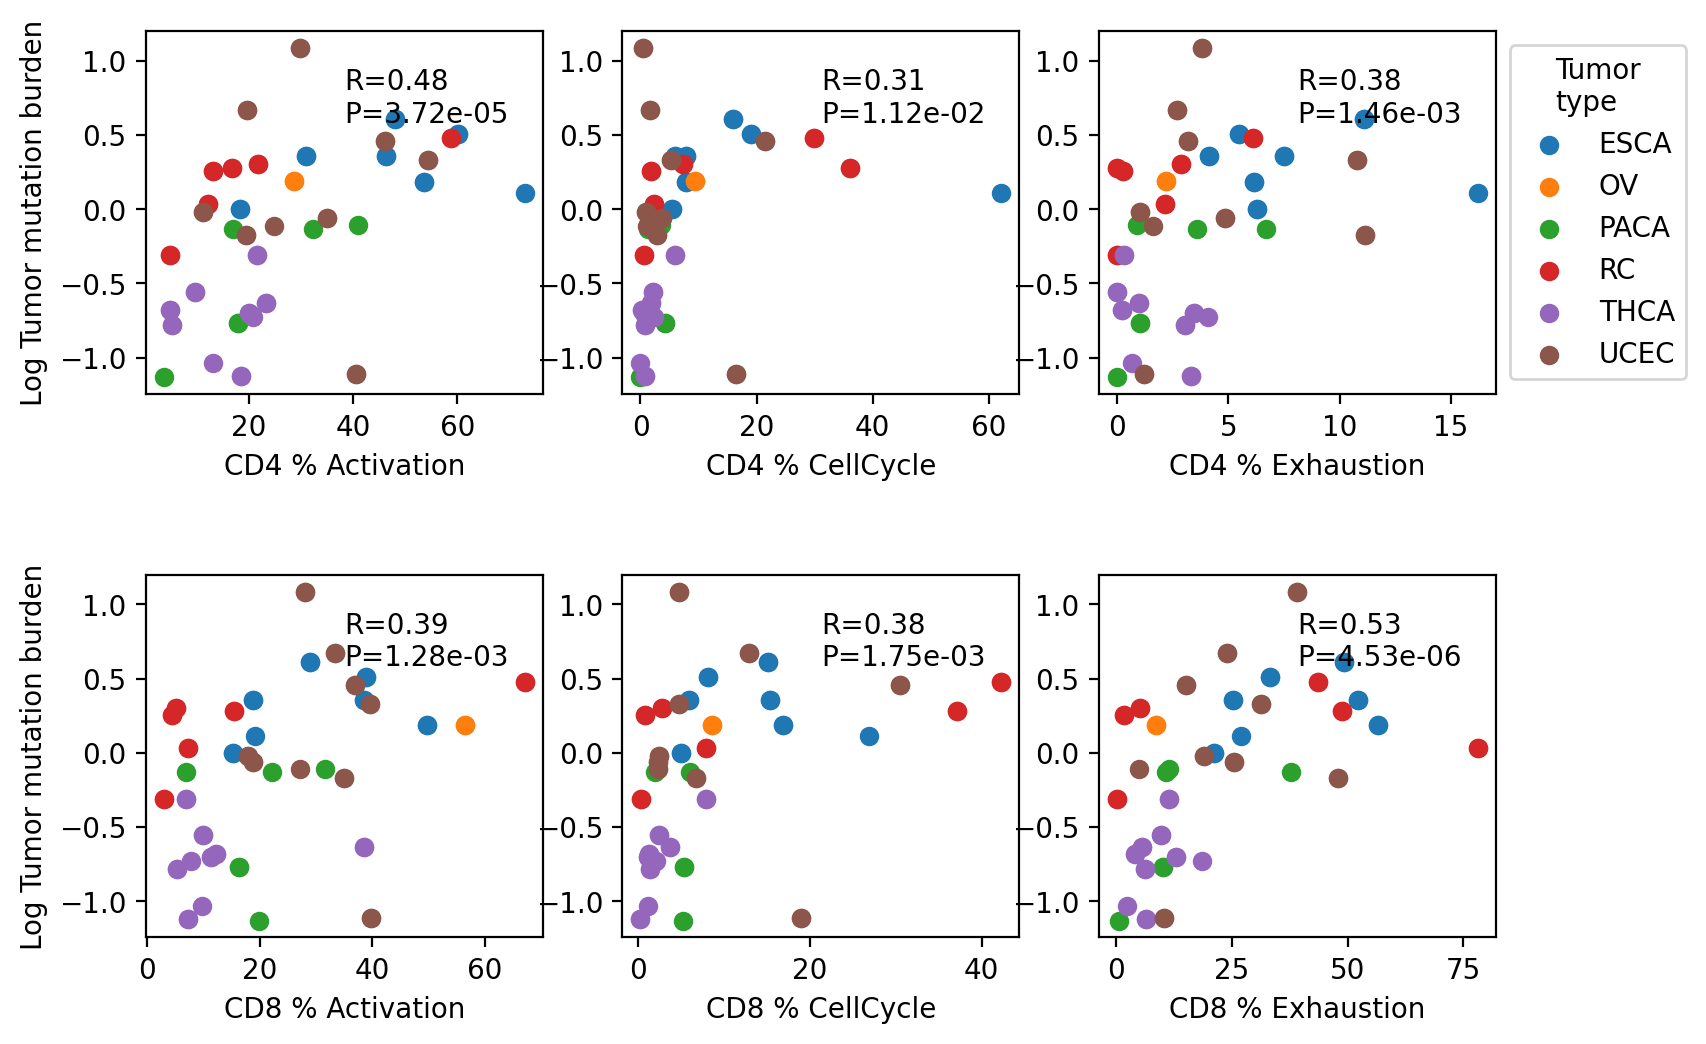

In [157]:
labelsize = 10
(fig,axes) = plt.subplots(2,3, figsize=(10,6), dpi=200, gridspec_kw={'hspace':.5, 'right':.8})

for i, lineage in enumerate(['CD4 Conv', 'CD8 Conv']):
    for j, readout in enumerate(['Activation_Status', 'CellCycle_Bin', 'Exhaustion_Bin']):

        ind = (meta_filt['lineage'] == lineage)
        dat = meta_filt.loc[ind, :]

        sample_stats = dat.groupby(['individual_fix', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={readout:'Ncell'})
        num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
        tumors_to_filt = num_tumors.index[num_tumors<mintumors]
        dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

        sample_average = (dat.groupby(['individual_fix', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
        sample_average = pd.merge(left=sample_average, right=sample_stats[['individual_fix', 'Ncell']], on='individual_fix', how='left')
        sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]

        sample_average_tumor = sample_average.loc[sample_average['loc']=='T', :]
        merged = pd.merge(left=sample_average_tumor, right=mutation_buden, left_on='individual_fix', right_on=0, how='inner')

        for (k,g) in merged.groupby('cancerType'):
            axes[i, j].scatter(g[readout], g['log'], label=k)
        
        R, P = pearsonr(merged[readout], merged['log'])
        axes[i,j].text(.5, .75, 'R=%.2f\nP=%.2e' % (R, P), fontsize=labelsize, transform=axes[i,j].transAxes)
        
        if j == 0:
            axes[i,j].set_ylabel('Log Tumor mutation burden', fontsize=labelsize)
            
        if (i == 0) and (j==2):
            axes[i,j].legend(bbox_to_anchor=(1,1), title='Tumor\ntype')
            
        axes[i,j].set_xlabel('%s %s' % (lineage.split(' ')[0], ('% '+readout.split('_')[0])), fontsize=labelsize)    

In [ ]:
ind = (meta_filt['lineage'] == lineage)
dat = meta_filt.loc[ind, :]

sample_stats = dat.groupby(['individual', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={'Activation_Status':'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

sample_average = (dat.groupby(['individual', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]

sample_average

In [87]:
def fix_name(x, pos1=0, pos2=3):
    words = x.split('.')
    return('.'.join([words[pos1], words[pos2]]))
sample_average['individual_fix'] = sample_average['individual'].apply(lambda x: fix_name(x))
ind = sample_average['cancerType'] == 'BC'
sample_average.loc[ind, 'individual_fix'] = sample_average.loc[ind, 'individual_fix'].apply(lambda x: x.replace('BRCA', 'BC'))

In [97]:
sample_average_tumor = sample_average.loc[sample_average['loc']=='T', :]
merged = pd.merge(left=sample_average_tumor, right=mutation_buden, left_on='individual_fix', right_on=0, how='inner')
merged.head()

,individual,loc,cancerType,CellCycle_Bin,Activation_Status,Exhaustion_Bin,Ncell,individual_fix,0,1,2
0,BRCA.thisStudy.BC.P20190123.T,T,BC,0.917431,4.357798,1.032110,872,BC.P20190123,BC.P20190123,BC,0.397868
1,BRCA.thisStudy.BC.P20190403.T,T,BC,0.265957,6.515957,0.664894,752,BC.P20190403,BC.P20190403,BC,0.233919
2,ESCA.thisStudy.ESCA.P20181114.T,T,ESCA,5.419580,18.356643,6.293706,572,ESCA.P20181114,ESCA.P20181114,ESCA,0.995432
3,ESCA.thisStudy.ESCA.P20181123.T,T,ESCA,5.939394,31.030303,7.515152,825,ESCA.P20181123,ESCA.P20181123,ESCA,2.265806
4,ESCA.thisStudy.ESCA.P20190404.T,T,ESCA,18.986083,60.139165,5.467197,1006,ESCA.P20190404,ESCA.P20190404,ESCA,3.223762


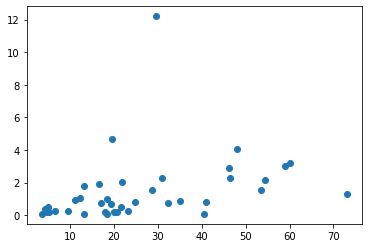

In [99]:
plt.scatter(merged['Activation_Status'], merged[2])

In [100]:
spearmanr(merged['Activation_Status'], merged[2])

SpearmanrResult(correlation=0.5633603238866397, pvalue=0.000188396798971437)

In [88]:
set(mutation_buden[0]) - set(sample_average['individual_fix'])

{'CHOL.P0216',
 'CRC.P0123',
 'CRC.P0215',
 'CRC.P0309',
 'CRC.P0411',
 'CRC.P0413',
 'CRC.P0701',
 'CRC.P0825',
 'CRC.P0909',
 'CRC.P1012',
 'CRC.P1207',
 'CRC.P1212',
 'CRC.P1228',
 'HCC.P0205',
 'HCC.P0322',
 'HCC.P0407',
 'HCC.P0508',
 'HCC.P1116',
 'LUNG.P0512',
 'LUNG.P0616A',
 'LUNG.P0616P',
 'LUNG.P0617',
 'LUNG.P0619',
 'LUNG.P0706',
 'LUNG.P0729',
 'LUNG.P0913',
 'LUNG.P1010',
 'LUNG.P1011',
 'LUNG.P1120',
 'LUNG.P1202',
 'LUNG.P1208',
 'LUNG.P1219',
 'OV.P20181225',
 'PACA.P20190307',
 'PACA.P20190909',
 'RC.P20191021',
 'RC.P20191023',
 'RC.P20191028',
 'STAD.P181019',
 'STAD.P181025',
 'STAD.P181026',
 'STAD.P181217',
 'STAD.P181227',
 'STAD.P190103',
 'STAD.P190118',
 'STAD.P190123',
 'STAD.P190124',
 'STAD.P190125',
 'UCEC.P20190722'}

In [92]:
sample_average.loc[sample_average['cancerType'] == 'HCC', :]

,individual,loc,cancerType,CellCycle_Bin,Activation_Status,Exhaustion_Bin,Ncell,individual_fix
32,HCC.QimingZhang2019.10X.D20171109.N,N,HCC,0.000000,3.816794,0.763359,131,HCC.D20171109
33,HCC.QimingZhang2019.10X.D20171109.T,T,HCC,9.302326,37.209302,0.000000,43,HCC.D20171109
34,HCC.QimingZhang2019.10X.D20171215.N,N,HCC,2.777778,3.703704,0.000000,108,HCC.D20171215
35,HCC.QimingZhang2019.10X.D20171215.T,T,HCC,2.622951,7.868852,0.983607,305,HCC.D20171215
36,HCC.QimingZhang2019.10X.D20180108.N,N,HCC,1.234568,2.469136,0.000000,81,HCC.D20180108
37,HCC.QimingZhang2019.10X.D20180108.T,T,HCC,7.692308,11.111111,0.000000,117,HCC.D20180108
38,HCC.QimingZhang2019.10X.D20180110.N,N,HCC,0.900901,9.609610,0.000000,333,HCC.D20180110
39,HCC.QimingZhang2019.10X.D20180110.T,T,HCC,1.336898,24.866310,1.871658,374,HCC.D20180110
40,HCC.QimingZhang2019.10X.D20180116.N,N,HCC,0.000000,5.357143,0.000000,56,HCC.D20180116
41,HCC.QimingZhang2019.10X.D20180116.T,T,HCC,5.095541,37.579618,0.636943,157,HCC.D20180116


In [62]:
meta['cancerType'].value_counts()

THCA    56956
UCEC    32652
RC      31176
ESCA    24882
BCC     21011
PACA    11504
HCC     10964
MM       8279
BC       7354
OV       4522
BCL      3493
LUNG     1205
FTC      1037
Name: cancerType, dtype: int64

In [73]:
mutation_buden.loc[mutation_buden[1] == 'HCC', :]

,0,1,2
22,HCC.P0205,HCC,2.738771
23,HCC.P0322,HCC,1.463766
24,HCC.P0407,HCC,4.401168
25,HCC.P0508,HCC,1.631042
26,HCC.P1116,HCC,0.897425


In [75]:
meta.loc[meta['cancerType'] == 'HCC', :].head().T

,AAAGATGAGCTGAAAT-1-D20171109_Nplus-10,AAAGTAGAGATATGGT-1-D20171109_Nplus-10,AAATGCCCAGCTCGCA-1-D20171109_Nplus-10,AACGTTGAGCTCAACT-1-D20171109_Nplus-10,AACTCTTAGTAGGCCA-1-D20171109_Nplus-10
patient,D20171109,D20171109,D20171109,D20171109,D20171109
cellID,AAAGATGAGCTGAAAT-1-D20171109_Nplus,AAAGTAGAGATATGGT-1-D20171109_Nplus,AAATGCCCAGCTCGCA-1-D20171109_Nplus,AACGTTGAGCTCAACT-1-D20171109_Nplus,AACTCTTAGTAGGCCA-1-D20171109_Nplus
libraryID,D20171109_Nplus,D20171109_Nplus,D20171109_Nplus,D20171109_Nplus,D20171109_Nplus
cancerType,HCC,HCC,HCC,HCC,HCC
loc,N,N,N,N,N
batchV,D20171109,D20171109,D20171109,D20171109,D20171109
TCR,NaN,NaN,NaN,NaN,NaN
dataset,HCC.YaoHe10X,HCC.YaoHe10X,HCC.YaoHe10X,HCC.YaoHe10X,HCC.YaoHe10X
ClusterID,HCC.YaoHe10X.C00,HCC.YaoHe10X.C00,HCC.YaoHe10X.C01,HCC.YaoHe10X.C16,HCC.YaoHe10X.C01
dataset.tech,YaoHe10X,YaoHe10X,YaoHe10X,YaoHe10X,YaoHe10X


In [56]:
len(set(mutation_buden[0]).intersection(set(sample_average['individual_fix']))), len(set(mutation_buden[0]))

(36, 88)

In [47]:
set(mutation_buden[0])

{'BC.P20190123',
 'BC.P20190403',
 'CHOL.P0216',
 'CRC.P0123',
 'CRC.P0215',
 'CRC.P0309',
 'CRC.P0411',
 'CRC.P0413',
 'CRC.P0701',
 'CRC.P0825',
 'CRC.P0909',
 'CRC.P1012',
 'CRC.P1207',
 'CRC.P1212',
 'CRC.P1228',
 'ESCA.P20181114',
 'ESCA.P20181123',
 'ESCA.P20190404',
 'ESCA.P20190410',
 'ESCA.P20190411',
 'ESCA.P20190613',
 'ESCA.P20190916',
 'HCC.P0205',
 'HCC.P0322',
 'HCC.P0407',
 'HCC.P0508',
 'HCC.P1116',
 'LUNG.P0512',
 'LUNG.P0616A',
 'LUNG.P0616P',
 'LUNG.P0617',
 'LUNG.P0619',
 'LUNG.P0706',
 'LUNG.P0729',
 'LUNG.P0913',
 'LUNG.P1010',
 'LUNG.P1011',
 'LUNG.P1120',
 'LUNG.P1202',
 'LUNG.P1208',
 'LUNG.P1219',
 'OV.P20181225',
 'OV.P20190304',
 'PACA.P20181121',
 'PACA.P20181128',
 'PACA.P20190225',
 'PACA.P20190306',
 'PACA.P20190307',
 'PACA.P20190515',
 'PACA.P20190909',
 'RC.P20181217',
 'RC.P20181224',
 'RC.P20190918',
 'RC.P20190919',
 'RC.P20190923',
 'RC.P20190925',
 'RC.P20191021',
 'RC.P20191023',
 'RC.P20191028',
 'STAD.P181019',
 'STAD.P181025',
 'STAD.P181026

In [ ]:
dat[['individual', 'loc', 'cancerType']] = dat[['individual', 'loc', 'cancerType']].astype(str)
sample_stats = dat.groupby(['individual', 'loc', 'cancerType']).count()[readout].reset_index().rename(columns={'Activation_Status':'Ncell'})
num_tumors = sample_stats.loc[(sample_stats['Ncell']>=mincells) & (sample_stats['loc']=='T'), 'cancerType'].value_counts()
tumors_to_filt = num_tumors.index[num_tumors<mintumors]
dat = dat.loc[~dat['cancerType'].isin(tumors_to_filt), :]

sample_average = (dat.groupby(['individual', 'loc', 'cancerType'])['CellCycle_Bin', 'Activation_Status', 'Exhaustion_Bin'].mean()*100).dropna().reset_index()
sample_average = pd.merge(left=sample_average, right=sample_stats[['individual', 'Ncell']], on='individual', how='left')
sample_average = sample_average.loc[sample_average['Ncell']>=mincells, :]
order = list(sample_average.loc[sample_average['loc'] == 'T', :].groupby('cancerType')[readout].mean().sort_values(ascending=False).index)

(fig,ax) = plt.subplots(1,1, figsize=(3,2), dpi=200)
sp = sns.stripplot(x='cancerType', y='Activation_Status', hue='loc', dodge=True, data=sample_average, order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
              zorder=-1)
sns.boxplot(x='cancerType', y=readout, data=sample_average, hue='loc', order=order, hue_order=['T', 'N'], palette="Set1", ax=ax,
            dodge=True, fliersize=0, showcaps=False, 
            showfliers=False, whiskerprops={'linewidth':.5}, boxprops={'facecolor':'None', 'linewidth':.5}, 
            medianprops={'color':'black', 'linewidth':.5}, zorder=5)

handles, labels = sp.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1), handles=handles[:2], labels=labels[:2], fontsize=8, markerscale=.5)



In [18]:
meta['cancerType'].value_counts()

THCA    56956
UCEC    32652
RC      31176
ESCA    24882
BCC     21011
PACA    11504
HCC     10964
MM       8279
BC       7354
OV       4522
BCL      3493
LUNG     1205
FTC      1037
Name: cancerType, dtype: int64

In [16]:
mutation_buden = pd.read_csv('../../../Data/PerDataset/Pancancer/panC.TMB.txt', sep='\t', header=None)
mutation_buden.head()

,0,1,2
0,BC.P20190123,BC,0.397868
1,BC.P20190403,BC,0.233919
2,CHOL.P0216,CHOL,0.989222
3,CRC.P0123,CRC,23.897304
4,CRC.P0215,CRC,2.801537


In [19]:
mutation_buden.loc[mutation_buden[1] == 'UCEC', :]

,0,1,2
78,UCEC.P20181122,UCEC,0.871232
79,UCEC.P20181211,UCEC,0.774656
80,UCEC.P20190213,UCEC,4.674233
81,UCEC.P20190305,UCEC,0.673494
82,UCEC.P20190312,UCEC,12.204689
83,UCEC.P20190625,UCEC,2.143195
84,UCEC.P20190717,UCEC,0.958131
85,UCEC.P20190722,UCEC,0.757408
86,UCEC.P20190910,UCEC,2.866282
87,UCEC.P20190911,UCEC,0.077164


In [21]:
meta.loc[meta['cancerType']=='UCEC', :]

,patient,cellID,libraryID,cancerType,loc,batchV,TCR,dataset,ClusterID,dataset.tech,...,ClusterID.harmony,sampleID,treatment,stype,patient.uid,tech,batch,n_counts,Activation_Score,Activation_Status
AAACCTGAGGTGACCA-72-28,UCEC.P20190312,AAACCTGAGGTGACCA-72,UCEC-P20190312-N,UCEC,N,UCEC.P20190312,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C05,zhangLab5P,...,C15,UCEC-P20190312-N,baseline,CD4,UCEC.thisStudy.UCEC.P20190312,10X,28,3699.0,0.093278,True
AAACCTGGTTGTACAC-72-28,UCEC.P20190312,AAACCTGGTTGTACAC-72,UCEC-P20190312-N,UCEC,N,UCEC.P20190312,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C00,zhangLab5P,...,C20,UCEC-P20190312-N,baseline,CD4,UCEC.thisStudy.UCEC.P20190312,10X,28,3368.0,0.058324,False
AAACGGGCAGCATACT-72-28,UCEC.P20190312,AAACGGGCAGCATACT-72,UCEC-P20190312-N,UCEC,N,UCEC.P20190312,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C03,zhangLab5P,...,C13,UCEC-P20190312-N,baseline,CD4,UCEC.thisStudy.UCEC.P20190312,10X,28,2889.0,0.019457,False
AAACGGGGTGCTTCTC-72-28,UCEC.P20190312,AAACGGGGTGCTTCTC-72,UCEC-P20190312-N,UCEC,N,UCEC.P20190312,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C00,zhangLab5P,...,C01,UCEC-P20190312-N,baseline,CD4,UCEC.thisStudy.UCEC.P20190312,10X,28,3005.0,0.184308,True
AAAGATGAGGCTCAGA-72-28,UCEC.P20190312,AAAGATGAGGCTCAGA-72,UCEC-P20190312-N,UCEC,N,UCEC.P20190312,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C16,zhangLab5P,...,C13,UCEC-P20190312-N,baseline,CD4,UCEC.thisStudy.UCEC.P20190312,10X,28,3260.0,0.044203,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGAACGTCGGCACT-88-29,UCEC.P20190911,TTGGAACGTCGGCACT-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C11,zhangLab5P,...,C28,UCEC-P20190911-T,baseline,CD8,UCEC.thisStudy.UCEC.P20190911,10X,29,2986.0,0.037106,False
TTGGAACTCACTTACT-88-29,UCEC.P20190911,TTGGAACTCACTTACT-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C02,zhangLab5P,...,C03,UCEC-P20190911-T,baseline,CD8,UCEC.thisStudy.UCEC.P20190911,10X,29,2308.0,0.011973,False
TTTACTGAGACCACGA-88-29,UCEC.P20190911,TTTACTGAGACCACGA-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C16,zhangLab5P,...,C17,UCEC-P20190911-T,baseline,CD8,UCEC.thisStudy.UCEC.P20190911,10X,29,8737.0,0.058761,False
TTTATGCAGGCAATTA-88-29,UCEC.P20190911,TTTATGCAGGCAATTA-88,UCEC-P20190911-T,UCEC,T,UCEC.P20190911,Prod,UCEC.zhangLab5P,UCEC.zhangLab5P.C15,zhangLab5P,...,C08,UCEC-P20190911-T,baseline,CD8,UCEC.thisStudy.UCEC.P20190911,10X,29,4514.0,0.001649,False
